In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.optimizers import Adam, SGD, Adamax, Nadam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping
import keras.backend as K
from keras.preprocessing import image

from keras_tqdm import TQDMNotebookCallback

import json
import os
import numpy as np
import pandas as pd
from Generator import DriveDataGenerator
from Cooking import checkAndCreateDir
import h5py
from PIL import Image, ImageDraw
import math
import matplotlib.pyplot as plt

# << The directory containing the cooked data from the previous step >>
COOKED_DATA_DIR = 'EndToEndLearningRawData/data_cooked/'

# << The directory in which the model output will be placed >>
MODEL_OUTPUT_DIR = 'model'

Using TensorFlow backend.


In [2]:

train_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'train.h5'), 'r')
eval_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'eval.h5'), 'r')
test_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'test.h5'), 'r')

num_train_examples = train_dataset['image'].shape[0]
num_eval_examples = eval_dataset['image'].shape[0]
num_test_examples = test_dataset['image'].shape[0]

batch_size=32

In [3]:
data_generator = DriveDataGenerator(rescale=1./255., horizontal_flip=True, brighten_range=0.4)
train_generator = data_generator.flow\
    (train_dataset['image'], train_dataset['previous_state'], train_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.95, roi=[76,135,0,255])
eval_generator = data_generator.flow\
    (eval_dataset['image'], eval_dataset['previous_state'], eval_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.95, roi=[76,135,0,255])

Actual Steering Angle = [0.09738467]


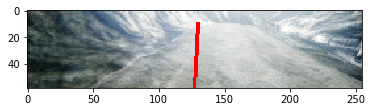

Actual Steering Angle = [0.11937133]


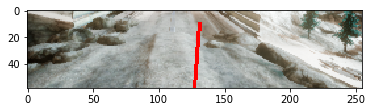

Actual Steering Angle = [0.08768733]


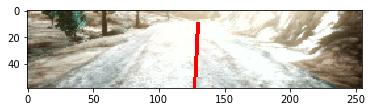

In [4]:
def draw_image_with_label(img, label, prediction=None):
    theta = label * 0.69 #Steering range for the car is +- 40 degrees -> 0.69 radians
    line_length = 50
    line_thickness = 3
    label_line_color = (255, 0, 0)
    prediction_line_color = (0, 0, 255)
    pil_image = image.array_to_img(img, K.image_data_format(), scale=True)
    print('Actual Steering Angle = {0}'.format(label))
    draw_image = pil_image.copy()
    image_draw = ImageDraw.Draw(draw_image)
    first_point = (int(img.shape[1]/2),img.shape[0])
    second_point = (int((img.shape[1]/2) + (line_length * math.sin(theta))), int(img.shape[0] - (line_length * math.cos(theta))))
    image_draw.line([first_point, second_point], fill=label_line_color, width=line_thickness)
    
    if (prediction is not None):
        print('Predicted Steering Angle = {0}'.format(prediction))
        print('L1 Error: {0}'.format(abs(prediction-label)))
        theta = prediction * 0.69
        second_point = (int((img.shape[1]/2) + (line_length * math.sin(theta))), int(img.shape[0] - (line_length * math.cos(theta))))
        image_draw.line([first_point, second_point], fill=prediction_line_color, width=line_thickness)
    
    del image_draw
    plt.imshow(draw_image)
    plt.show()

[sample_batch_train_data, sample_batch_test_data] = next(train_generator)
for i in range(0, 3, 1):
    draw_image_with_label(sample_batch_train_data[0][i], sample_batch_test_data[i])

In [5]:
image_input_shape = sample_batch_train_data[0].shape[1:]
state_input_shape = sample_batch_train_data[1].shape[1:]
activation = 'relu'

#Create the convolutional stacks
pic_input = Input(shape=image_input_shape)

img_stack = Conv2D(16, (3, 3), name="convolution0", padding='same', activation=activation)(pic_input)
img_stack = MaxPooling2D(pool_size=(2,2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution1')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution2')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Flatten()(img_stack)
img_stack = Dropout(0.2)(img_stack)

#Inject the state input
state_input = Input(shape=state_input_shape)
merged = concatenate([img_stack, state_input])

# Add a few dense layers to finish the model
merged = Dense(64, activation=activation, name='dense0')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(10, activation=activation, name='dense2')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1, name='output')(merged)

adam = Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model = Model(inputs=[pic_input, state_input], outputs=merged)
model.compile(optimizer=adam, loss='mse')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 59, 255, 3)   0                                            
__________________________________________________________________________________________________
convolution0 (Conv2D)           (None, 59, 255, 16)  448         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 29, 127, 16)  0           convolution0[0][0]               
__________________________________________________________________________________________________
convolution1 (Conv2D)           (None, 29, 127, 32)  4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [7]:
plateau_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
checkpoint_filepath = os.path.join(MODEL_OUTPUT_DIR, 'models', '{0}_model.{1}-{2}.h5'.format('model', '{epoch:02d}', '{val_loss:.7f}'))
checkAndCreateDir(checkpoint_filepath)
checkpoint_callback = ModelCheckpoint(checkpoint_filepath, save_best_only=True, verbose=1)
csv_callback = CSVLogger(os.path.join(MODEL_OUTPUT_DIR, 'training_log.csv'))
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
callbacks=[plateau_callback, csv_callback, checkpoint_callback, early_stopping_callback, TQDMNotebookCallback()]

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=num_train_examples//batch_size, epochs=1, callbacks=callbacks,\
                   validation_data=eval_generator, validation_steps=num_eval_examples//batch_size, verbose=2)

Epoch 1/1


In [ ]:
[sample_batch_train_data, sample_batch_test_data] = next(train_generator)
predictions = model.predict([sample_batch_train_data[0], sample_batch_train_data[1]])
for i in range(0, 3, 1):
    draw_image_with_label(sample_batch_train_data[0][i], sample_batch_test_data[i], predictions[i])